## Track the plasma motion

Cite this GitHub url: https://github.com/hayesla/DynaSun_workshop/blob/main/sunpy_dynasun_tutorial.ipynb

In [451]:
import warnings
warnings.filterwarnings('ignore')

import glob
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import sunpy.map
import matplotlib.pyplot as plt
# from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize, LogNorm
# from matplotlib.colorbar import ColorbarBase
import matplotlib.dates as mdates
import matplotlib.lines as mlines
from astropy.visualization import ImageNormalize, SqrtStretch, LogStretch, AsymmetricPercentileInterval, AsinhStretch
import astropy.units as u
from astropy.coordinates import SkyCoord, SkyOffsetFrame
from scipy.interpolate import interp1d
from sunpy.coordinates import SphericalScreen
from scipy.stats import linregress
from sunpy.sun import constants as const
from tqdm import tqdm

import os
import sys
# Construct the full path to the scripts directory
script_path = os.path.abspath('./scripts')

# Add the scripts directory to sys.path
if script_path not in sys.path:
    sys.path.append(script_path)

import solar_data_utils as myfuncs
# Reload to update with new changes
import importlib
importlib.reload(myfuncs)

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.format'] = 'png'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

import matplotlib
import sunpy.visualization.colormaps as cm

sdoaia171 = matplotlib.colormaps['sdoaia171']
sdoaia193 = matplotlib.colormaps['sdoaia193']
sdoaia211 = matplotlib.colormaps['sdoaia211']
sdoaia304 = matplotlib.colormaps['sdoaia304']

data_dir = '/home/mnedal/data'

In [ ]:
dict_maps = {
    '171A': [],
    '193A': [],
    '211A': [],
    '304A': []
}

# AIA 304 &Aring;

In [172]:
start = '2024-05-14T17:00:00'
end   = '2024-05-14T18:59:00'
channel = 304
data_type = 'highres'

# Check if the datetime is a string
if isinstance(start, str) and isinstance(end, str):
    dt_dict = myfuncs.split_datetime(start=start, end=end)

# Check if the datetime is a pandas.Timestamp
elif isinstance(start, pd.Timestamp) and isinstance(end, pd.Timestamp):
    dt_dict = myfuncs.split_datetime(start=str(start).replace(' ','T'), end=str(end).replace(' ','T'))

data_path = f'{data_dir}/AIA/{channel}A/{data_type}/lv15'
data = sorted(glob.glob(f'{data_path}/aia*{channel}A_*.fits'))

start_pattern = f"aia*{channel}A_{dt_dict['start_year']}_{dt_dict['start_month']}_{dt_dict['start_day']}T{dt_dict['start_hour']}_{dt_dict['start_minute']}*"
end_pattern   = f"aia*{channel}A_{dt_dict['end_year']}_{dt_dict['end_month']}_{dt_dict['end_day']}T{dt_dict['end_hour']}_{dt_dict['end_minute']}*"

first_file_to_find = sorted(glob.glob(f'{data_path}/{start_pattern}*.fits'))
last_file_to_find  = sorted(glob.glob(f'{data_path}/{end_pattern}*.fits'))

idx1 = data.index(first_file_to_find[0])
idx2 = data.index(last_file_to_find[0])

chosen_files = data[idx1:idx2]

map_objects = []
with tqdm(total=len(chosen_files), desc='Loading the maps ...') as pbar:
    for i, file in enumerate(chosen_files):
        # load the file as a sunpy map
        m = sunpy.map.Map(file)
        map_objects.append(m)
        pbar.update(1)
        # print(f'AIA {channel}A lv1.5-image {i} is loaded')

Loading the maps ...: 100%|████████████████████████████████████████████████████████████████████| 592/592 [04:56<00:00,  2.00it/s]


In [174]:
len(map_objects), map_objects[0].meta['t_obs'], map_objects[-1].meta['t_obs']

(592, '2024-05-14T17:00:06.59Z', '2024-05-14T18:58:54.58Z')

In [ ]:
dict_maps['304A'] = map_objects

NameError: name 'slitt1' is not defined

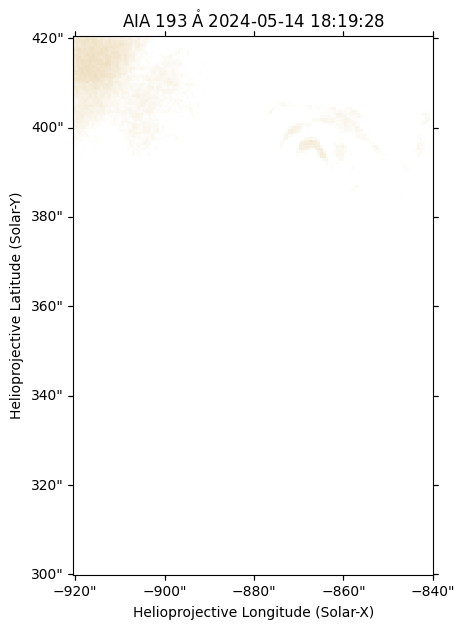

In [210]:
idx = 177
m = map_objects[idx]
norm = ImageNormalize(vmin=0, vmax=5e2, stretch=AsinhStretch()) # SqrtStretch, LogStretch, AsinhStretch

# crop the region of interest
top_right   = SkyCoord(-840*u.arcsec, 420*u.arcsec, frame=m.coordinate_frame)
bottom_left = SkyCoord(-920*u.arcsec, 300*u.arcsec, frame=m.coordinate_frame)
m_submap = m.submap(bottom_left, top_right=top_right)

# define a line over the vortex
slit = SkyCoord(
    Tx=[-877, -885]*u.arcsec,
    Ty=[385, 370]*u.arcsec,
    frame=m_submap.coordinate_frame
)

fig = plt.figure(figsize=[5,7])
ax = fig.add_subplot(projection=m_submap)
m_submap.plot(axes=ax, norm=norm)
ax.plot_coord(slit, color='white', ls=':', lw=3)

# Convert the slit coordinates to pixel coordinates for annotation
start_pix, end_pix = m_submap.world_to_pixel(slit)
x1pix, y1pix = start_pix.value
# x2pix, y2pix = end_pix
# Annotate at the tip of the slit using pixel coordinates
ax.annotate('1', xy=(x1pix, y1pix), xytext=(0,180),
            textcoords='offset points', color='w', fontsize=15)

# ax.grid(False)
fig.tight_layout()
plt.show()

In [81]:
# # take the slit coordinates and maps them onto the pixel grid of the solar image
# slit_pixelated = sunpy.map.pixelate_coord_path(m, slit)

# # how far the slit extends in terms of physical distance on the map
# slit_distance = slit_pixelated.separation(slit_pixelated[0])

In [98]:
# track how intensity evolves along the slit over the sequence of solar images
for m in map_objects:
    m.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=5e2, stretch=AsinhStretch())

intensity_stack = []
with tqdm(total=len(map_objects), desc='Stack intensities ...') as pbar:
    for m in map_objects:
        with SphericalScreen(m.observer_coordinate):
            _slit_pixelated = sunpy.map.pixelate_coord_path(m, slit)
        _slit_distance = _slit_pixelated.separation(_slit_pixelated[0])
        intensity = sunpy.map.sample_at_coords(m, _slit_pixelated)
        f_interp = interp1d(_slit_distance.to_value('arcsec'), intensity.value, fill_value='extrapolate', kind='linear')
        intensity_interp = f_interp(slit_distance.to_value('arcsec'))
        intensity_stack.append(u.Quantity(intensity_interp, intensity.unit))
        pbar.update(1)

# intensity_stack = u.Quantity(intensity_stack)

# get the time array and the distance along slit in arcsec
time_array = [m.date.datetime for m in map_objects]
distance = slit_distance.to(u.arcsec)

Stack intensities ...: 100%|███████████████████████████████████████████████████████████████████| 592/592 [01:56<00:00,  5.09it/s]


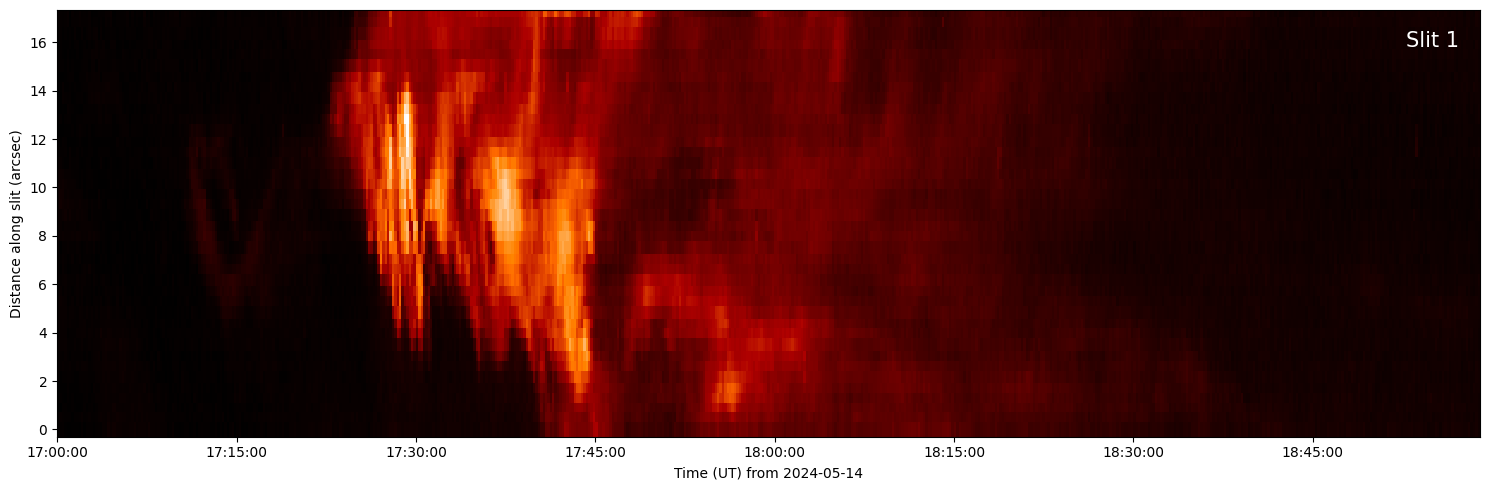

In [108]:
fig, ax = plt.subplots(figsize=[15,5])
ax.pcolormesh(time_array, distance.value, np.array(intensity_stack).T,
              norm=ImageNormalize(stretch=AsinhStretch()),
              cmap=sdoaia304
             )
ax.text(0.985, 0.95, 'Slit 1', transform=ax.transAxes,
        fontsize=15, color='white', verticalalignment='top', horizontalalignment='right',
        # bbox=dict(facecolor='white', alpha=0.5)
       )
ax.set_ylabel('Distance along slit (arcsec)')
ax.set_xlabel(f"Time (UT) from {time_array[0].strftime('%Y-%m-%d')}")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
fig.tight_layout()
plt.show()

In [ ]:
start_time = datetime(2024, 5, 14, 17, 18, 0)  # Replace with your actual start time
end_time = datetime(2024, 5, 14, 17, 48, 0)    # Replace with your actual end time
start_distance = 17.5                          # Replace with your actual start distance
end_distance = 0.5                             # Replace with your actual end distance

# get the radius of the solar disk
sol_rad = const.equatorial_radius.to(u.km)

# conversion factor from arcsec to km
conversion_factor = sol_rad/m_run.rsun_obs
print(conversion_factor)

# Convert datetime to numerical format (Matplotlib date format)
start_num = mdates.date2num(start_time)
end_num = mdates.date2num(end_time)

# Perform linear fit
slope, intercept, r_value, p_value, std_err = linregress([start_num, end_num],
                                                         [start_distance, end_distance])
# # convert distance from arcsec to km
# distance_km = distance * conversion_factor
# distance_diff_km = distance_km.diff()

# # calculate the time difference in seconds
# time_diff_s = time_array.diff().dt.total_seconds()

# # calculate the speed in km/s
# speed_km_s = distance_diff_km / time_diff_s
# print(speed_km_s)

# Generate x values (time) for plotting the fit line
fit_times = np.linspace(start_num, end_num, 100)

# Generate y values (distance) for the fit line using the linear equation
fit_distances = slope*fit_times + intercept

# Calculate speed (in arcseconds per second)
# Matplotlib's date2num function returns the number of days, so convert accordingly
time_diff_seconds = (end_time - start_time).total_seconds()
speed = ((end_distance - start_distance)*u.arcsec * conversion_factor) / (time_diff_seconds*u.second)
print(speed)

In [ ]:
# fig, ax = plt.subplots(figsize=[15,5])
# ax.pcolormesh(time_array, distance.value, intensity_stack.value.T,
#                # norm=ImageNormalize(stretch=AsinhStretch()),
#                # norm=norm,
#                cmap='Greys_r')
# ax.text(0.985, 0.95, 'Slit 1', transform=ax.transAxes,
#         fontsize=15, color='crimson', verticalalignment='top', horizontalalignment='right',
#         bbox=dict(facecolor='white', alpha=0.5))

# # Plot the linear fit line
# ax.plot(fit_times, fit_distances, color='crimson', linestyle='--', linewidth=3, label=f'Linear fit: {speed.value:.2f} km/s')
# ax.legend(loc='lower right')
# ax.set_ylabel('Distance along slit (arcsec)')
# ax.set_xlabel(f"Time (UT) from {time_array[0].strftime('%Y-%m-%d')}")
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
# plt.show()

distance_Mm = (distance * conversion_factor).value/1e3
fit_distance_Mm = (fit_distances * conversion_factor).value/1e3



fig = plt.figure(figsize=[15,4])
ax = fig.add_subplot(121, projection=m_run)
m_run.plot(axes=ax, cmap='Greys_r', norm=norm)
ax.plot_coord(traced_loop, color='crimson', lw=2)

# Convert the slit coordinates to pixel coordinates for annotation
start_pix, end_pix = m_run.world_to_pixel(traced_loop)
x1pix, y1pix = start_pix
x2pix, y2pix = end_pix
# Annotate at the tip of the slit using pixel coordinates
ax.annotate('1', xy=(x1pix.value, y1pix.value), xytext=(0,45), textcoords='offset points', color='crimson', fontsize=15)
ax.grid(False)

ax = fig.add_subplot(122)
# ax.pcolormesh(time_array, distance_Mm, intensity_stack.value.T, cmap='Greys_r')
ax.pcolormesh(time_array, distance_Mm, np.array(intensity_stack).T, cmap='Greys_r')
ax.text(0.985, 0.95, 'Slit 1', transform=ax.transAxes,
        fontsize=15, color='crimson', verticalalignment='top', horizontalalignment='right',
        bbox=dict(facecolor='white', alpha=0.5))

# Plot the linear fit line
ax.plot(fit_times, fit_distance_Mm, color='crimson', linestyle='--', linewidth=3, label=f'Linear fit: {speed.value:.2f} km/s')
ax.legend(loc='lower right')
ax.set_ylabel('Distance (Mm)')
ax.set_xlabel(f"Time (UT) from {time_array[0].strftime('%Y-%m-%d')}")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

fig.tight_layout()
plt.show()

In [ ]:
# Temoplate ...
fig = plt.figure(figsize=[20,6])

# Define the grid layout
# 1st column: 1 row, 1 column
# 2nd column: 4 rows, 2 columns
# We'll use GridSpec to manage the layout
from matplotlib.gridspec import GridSpec

# Create a GridSpec with 4 rows and 3 columns
gs = GridSpec(4, 3, figure=fig)

# Add the first subplot (full height of the first column)
ax1 = fig.add_subplot(gs[:, 0])
ax1.set_title('Left Column')

# Add subplots for the second column (4 rows x 2 columns)
ax2 = fig.add_subplot(gs[0, 1:2])
ax3 = fig.add_subplot(gs[1, 1:2])
ax4 = fig.add_subplot(gs[2, 1:2])
ax5 = fig.add_subplot(gs[3, 1:2])

# Add subplots for the third column (4 rows x 2 columns)
ax6 = fig.add_subplot(gs[0, 2:])
ax7 = fig.add_subplot(gs[1, 2:])
ax8 = fig.add_subplot(gs[2, 2:])
ax9 = fig.add_subplot(gs[3, 2:])

# Titles for each subplot in the second and third columns
ax2.set_title('Middle Column, Row 1')
ax3.set_title('Middle Column, Row 2')
ax4.set_title('Middle Column, Row 3')
ax5.set_title('Middle Column, Row 4')

ax6.set_title('Right Column, Row 1')
ax7.set_title('Right Column, Row 2')
ax8.set_title('Right Column, Row 3')
ax9.set_title('Right Column, Row 4')

fig.tight_layout()
plt.show()

# AIA 171 &Aring;

In [116]:
channel = 171

# Check if the datetime is a string
if isinstance(start, str) and isinstance(end, str):
    dt_dict = myfuncs.split_datetime(start=start, end=end)

# Check if the datetime is a pandas.Timestamp
elif isinstance(start, pd.Timestamp) and isinstance(end, pd.Timestamp):
    dt_dict = myfuncs.split_datetime(start=str(start).replace(' ','T'), end=str(end).replace(' ','T'))

data_path = f'{data_dir}/AIA/{channel}A/{data_type}/lv15'
data = sorted(glob.glob(f'{data_path}/aia*{channel}A_*.fits'))

start_pattern = f"aia*{channel}A_{dt_dict['start_year']}_{dt_dict['start_month']}_{dt_dict['start_day']}T{dt_dict['start_hour']}_{dt_dict['start_minute']}*"
end_pattern   = f"aia*{channel}A_{dt_dict['end_year']}_{dt_dict['end_month']}_{dt_dict['end_day']}T{dt_dict['end_hour']}_{dt_dict['end_minute']}*"

first_file_to_find = sorted(glob.glob(f'{data_path}/{start_pattern}*.fits'))
last_file_to_find  = sorted(glob.glob(f'{data_path}/{end_pattern}*.fits'))

idx1 = data.index(first_file_to_find[0])
idx2 = data.index(last_file_to_find[0])

chosen_files = data[idx1:idx2]

map_objects = []
with tqdm(total=len(chosen_files), desc=f'Loading AIA {channel}A maps ...') as pbar:
    for i, file in enumerate(chosen_files):
        # load the file as a sunpy map
        m = sunpy.map.Map(file)
        map_objects.append(m)
        pbar.update(1)

Loading AIA 171A maps ...: 100%|███████████████████████████████████████████████████████████████| 582/582 [01:43<00:00,  5.61it/s]


In [117]:
len(map_objects), map_objects[0].meta['t_obs'], map_objects[-1].meta['t_obs']

(582, '2024-05-14T17:00:10.34Z', '2024-05-14T18:58:58.35Z')

In [119]:
dict_maps['171A'] = map_objects

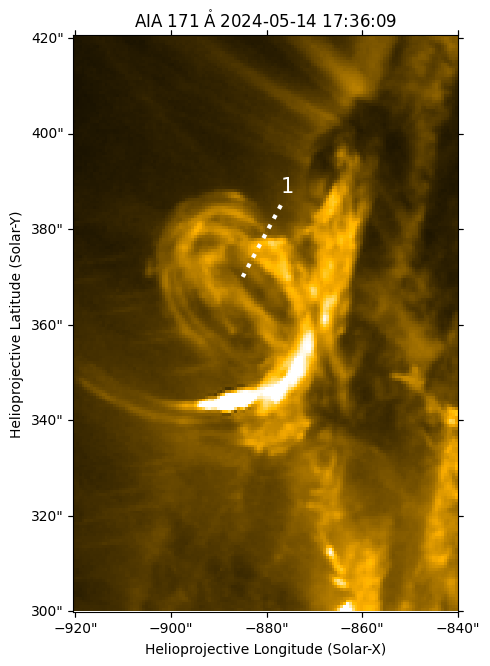

In [130]:
idx = 177
m = map_objects[idx]
norm = ImageNormalize(vmin=0, vmax=7e3, stretch=AsinhStretch())

# crop the region of interest
top_right   = SkyCoord(-840*u.arcsec, 420*u.arcsec, frame=m.coordinate_frame)
bottom_left = SkyCoord(-920*u.arcsec, 300*u.arcsec, frame=m.coordinate_frame)
m_submap = m.submap(bottom_left, top_right=top_right)

# define a line over the vortex
slit = SkyCoord(
    Tx=[-877, -885]*u.arcsec,
    Ty=[385, 370]*u.arcsec,
    frame=m_submap.coordinate_frame
)

fig = plt.figure(figsize=[5,7])
ax = fig.add_subplot(projection=m_submap)
m_submap.plot(axes=ax, norm=norm)
ax.plot_coord(slit, color='white', ls=':', lw=3)

# Convert the slit coordinates to pixel coordinates for annotation
start_pix, end_pix = m_submap.world_to_pixel(slit)
x1pix, y1pix = start_pix.value
# Annotate at the tip of the slit using pixel coordinates
ax.annotate('1', xy=(x1pix, y1pix), xytext=(0,180),
            textcoords='offset points', color='w', fontsize=15)
ax.grid(False)
fig.tight_layout()
plt.show()

In [127]:
# track how intensity evolves along the slit over the sequence of solar images
for m in map_objects:
    m.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=7e3, stretch=AsinhStretch())

intensity_stack = []
with tqdm(total=len(map_objects), desc='Stack intensities ...') as pbar:
    for m in map_objects:
        with SphericalScreen(m.observer_coordinate):
            _slit_pixelated = sunpy.map.pixelate_coord_path(m, slit)
        _slit_distance = _slit_pixelated.separation(_slit_pixelated[0])
        intensity = sunpy.map.sample_at_coords(m, _slit_pixelated)
        f_interp = interp1d(_slit_distance.to_value('arcsec'), intensity.value, fill_value='extrapolate', kind='linear')
        intensity_interp = f_interp(slit_distance.to_value('arcsec'))
        intensity_stack.append(u.Quantity(intensity_interp, intensity.unit))
        pbar.update(1)

# get the time array and the distance along slit in arcsec
time_array = [m.date.datetime for m in map_objects]
distance = slit_distance.to(u.arcsec)

Stack intensities ...: 100%|███████████████████████████████████████████████████████████████████| 582/582 [02:52<00:00,  3.38it/s]


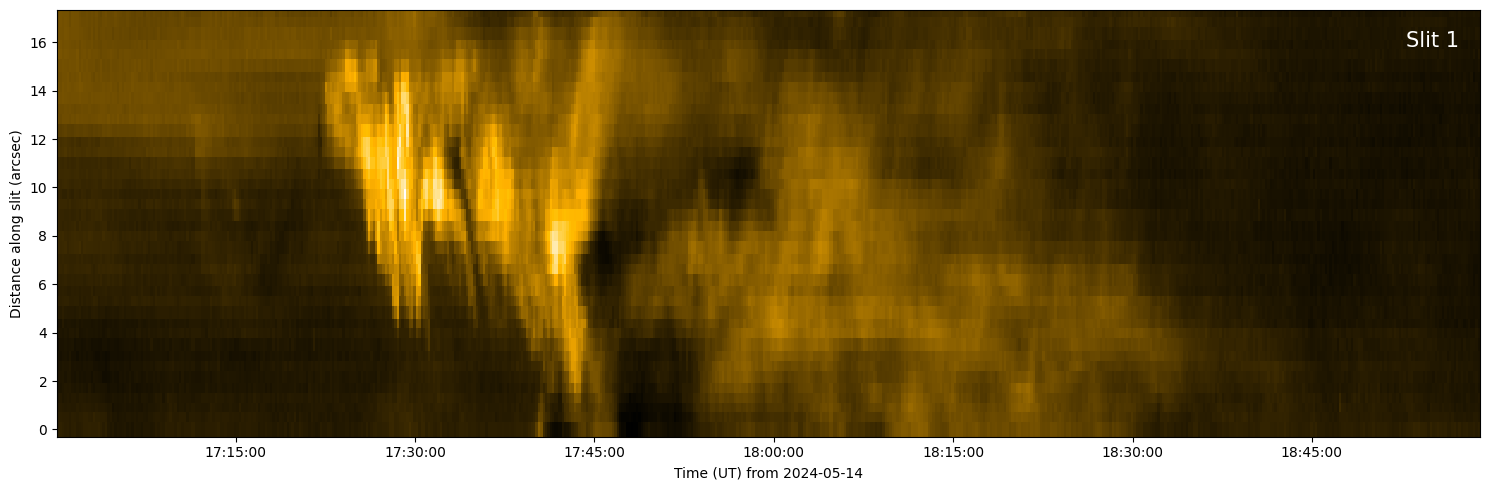

In [129]:
fig, ax = plt.subplots(figsize=[15,5])
ax.pcolormesh(time_array, distance.value, np.array(intensity_stack).T,
              norm=ImageNormalize(stretch=AsinhStretch()),
              cmap=sdoaia171)
ax.text(0.985, 0.95, 'Slit 1', transform=ax.transAxes,
        fontsize=15, color='white', verticalalignment='top', horizontalalignment='right')
ax.set_ylabel('Distance along slit (arcsec)')
ax.set_xlabel(f"Time (UT) from {time_array[0].strftime('%Y-%m-%d')}")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
fig.tight_layout()
plt.show()

# AIA 193 &Aring;

In [176]:
channel = 193

# Check if the datetime is a string
if isinstance(start, str) and isinstance(end, str):
    dt_dict = myfuncs.split_datetime(start=start, end=end)

# Check if the datetime is a pandas.Timestamp
elif isinstance(start, pd.Timestamp) and isinstance(end, pd.Timestamp):
    dt_dict = myfuncs.split_datetime(start=str(start).replace(' ','T'), end=str(end).replace(' ','T'))

data_path = f'{data_dir}/AIA/{channel}A/{data_type}/lv15'
data = sorted(glob.glob(f'{data_path}/aia*{channel}A_*.fits'))

start_pattern = f"aia*{channel}A_{dt_dict['start_year']}_{dt_dict['start_month']}_{dt_dict['start_day']}T{dt_dict['start_hour']}_{dt_dict['start_minute']}*"
end_pattern   = f"aia*{channel}A_{dt_dict['end_year']}_{dt_dict['end_month']}_{dt_dict['end_day']}T{dt_dict['end_hour']}_{dt_dict['end_minute']}*"

first_file_to_find = sorted(glob.glob(f'{data_path}/{start_pattern}*.fits'))
last_file_to_find  = sorted(glob.glob(f'{data_path}/{end_pattern}*.fits'))

idx1 = data.index(first_file_to_find[0])
idx2 = data.index(last_file_to_find[0])

chosen_files = data[idx1:idx2]

map_objects = []
with tqdm(total=len(chosen_files), desc=f'Loading AIA {channel}A maps ...') as pbar:
    for i, file in enumerate(chosen_files):
        # load the file as a sunpy map
        m = sunpy.map.Map(file)
        map_objects.append(m)
        pbar.update(1)

Loading AIA 193A maps ...: 100%|███████████████████████████████████████████████████████████████| 254/254 [00:35<00:00,  7.10it/s]


In [177]:
len(map_objects), map_objects[0].meta['t_obs'], map_objects[-1].meta['t_obs']

(254, '2024-05-14T17:00:07.23Z', '2024-05-14T18:58:17.84Z')

In [188]:
dict_maps['193A'] = map_objects

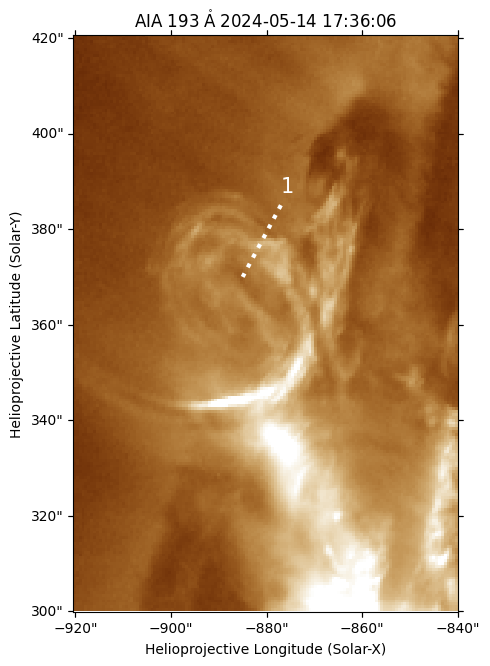

In [184]:
idx = 71
m = map_objects[idx]
norm = ImageNormalize(vmin=0, vmax=8e3, stretch=AsinhStretch())

# crop the region of interest
top_right   = SkyCoord(-840*u.arcsec, 420*u.arcsec, frame=m.coordinate_frame)
bottom_left = SkyCoord(-920*u.arcsec, 300*u.arcsec, frame=m.coordinate_frame)
m_submap = m.submap(bottom_left, top_right=top_right)

# define a line over the vortex
slit = SkyCoord(
    Tx=[-877, -885]*u.arcsec,
    Ty=[385, 370]*u.arcsec,
    frame=m_submap.coordinate_frame
)

fig = plt.figure(figsize=[5,7])
ax = fig.add_subplot(projection=m_submap)
m_submap.plot(axes=ax, norm=norm)
ax.plot_coord(slit, color='white', ls=':', lw=3)

# Convert the slit coordinates to pixel coordinates for annotation
start_pix, end_pix = m_submap.world_to_pixel(slit)
x1pix, y1pix = start_pix.value
# Annotate at the tip of the slit using pixel coordinates
ax.annotate('1', xy=(x1pix, y1pix), xytext=(0,180),
            textcoords='offset points', color='w', fontsize=15)
ax.grid(False)
fig.tight_layout()
plt.show()

In [185]:
# track how intensity evolves along the slit over the sequence of solar images
for m in map_objects:
    m.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=8e3, stretch=AsinhStretch())

intensity_stack = []
with tqdm(total=len(map_objects), desc='Stack intensities ...') as pbar:
    for m in map_objects:
        with SphericalScreen(m.observer_coordinate):
            _slit_pixelated = sunpy.map.pixelate_coord_path(m, slit)
        _slit_distance = _slit_pixelated.separation(_slit_pixelated[0])
        intensity = sunpy.map.sample_at_coords(m, _slit_pixelated)
        f_interp = interp1d(_slit_distance.to_value('arcsec'), intensity.value, fill_value='extrapolate', kind='linear')
        intensity_interp = f_interp(slit_distance.to_value('arcsec'))
        intensity_stack.append(u.Quantity(intensity_interp, intensity.unit))
        pbar.update(1)

# get the time array and the distance along slit in arcsec
time_array = [m.date.datetime for m in map_objects]
distance = slit_distance.to(u.arcsec)

Stack intensities ...: 100%|███████████████████████████████████████████████████████████████████| 254/254 [00:56<00:00,  4.46it/s]


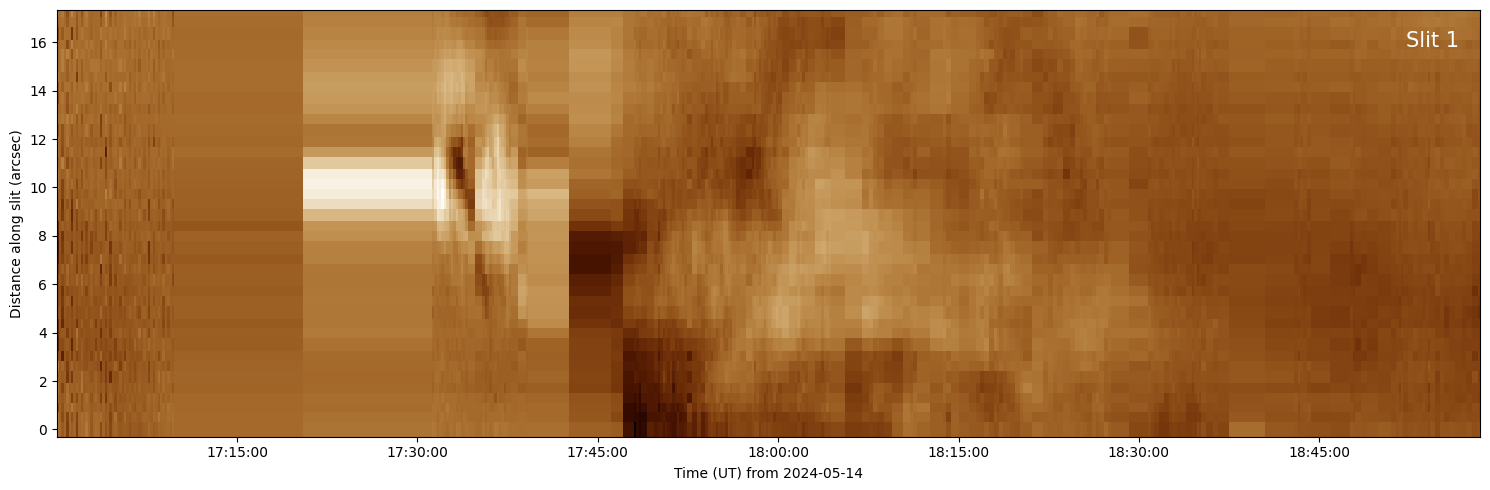

In [189]:
fig, ax = plt.subplots(figsize=[15,5])
ax.pcolormesh(time_array, distance.value, np.array(intensity_stack).T,
              norm=ImageNormalize(stretch=AsinhStretch()),
              cmap=sdoaia193)
ax.text(0.985, 0.95, 'Slit 1', transform=ax.transAxes,
        fontsize=15, color='white', verticalalignment='top', horizontalalignment='right')
ax.set_ylabel('Distance along slit (arcsec)')
ax.set_xlabel(f"Time (UT) from {time_array[0].strftime('%Y-%m-%d')}")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
fig.tight_layout()
plt.show()

# AIA 211 &Aring;

In [132]:
channel = 211

# Check if the datetime is a string
if isinstance(start, str) and isinstance(end, str):
    dt_dict = myfuncs.split_datetime(start=start, end=end)

# Check if the datetime is a pandas.Timestamp
elif isinstance(start, pd.Timestamp) and isinstance(end, pd.Timestamp):
    dt_dict = myfuncs.split_datetime(start=str(start).replace(' ','T'), end=str(end).replace(' ','T'))

data_path = f'{data_dir}/AIA/{channel}A/{data_type}/lv15'
data = sorted(glob.glob(f'{data_path}/aia*{channel}A_*.fits'))

start_pattern = f"aia*{channel}A_{dt_dict['start_year']}_{dt_dict['start_month']}_{dt_dict['start_day']}T{dt_dict['start_hour']}_{dt_dict['start_minute']}*"
end_pattern   = f"aia*{channel}A_{dt_dict['end_year']}_{dt_dict['end_month']}_{dt_dict['end_day']}T{dt_dict['end_hour']}_{dt_dict['end_minute']}*"

first_file_to_find = sorted(glob.glob(f'{data_path}/{start_pattern}*.fits'))
last_file_to_find  = sorted(glob.glob(f'{data_path}/{end_pattern}*.fits'))

idx1 = data.index(first_file_to_find[0])
idx2 = data.index(last_file_to_find[0])

chosen_files = data[idx1:idx2]

map_objects = []
with tqdm(total=len(chosen_files), desc=f'Loading AIA {channel}A maps ...') as pbar:
    for i, file in enumerate(chosen_files):
        # load the file as a sunpy map
        m = sunpy.map.Map(file)
        map_objects.append(m)
        pbar.update(1)

Loading AIA 211A maps ...: 100%|███████████████████████████████████████████████████████████████| 452/452 [02:01<00:00,  3.71it/s]


In [133]:
len(map_objects), map_objects[0].meta['t_obs'], map_objects[-1].meta['t_obs']

(452, '2024-05-14T17:00:13.21Z', '2024-05-14T18:58:59.08Z')

In [134]:
dict_maps['211A'] = map_objects

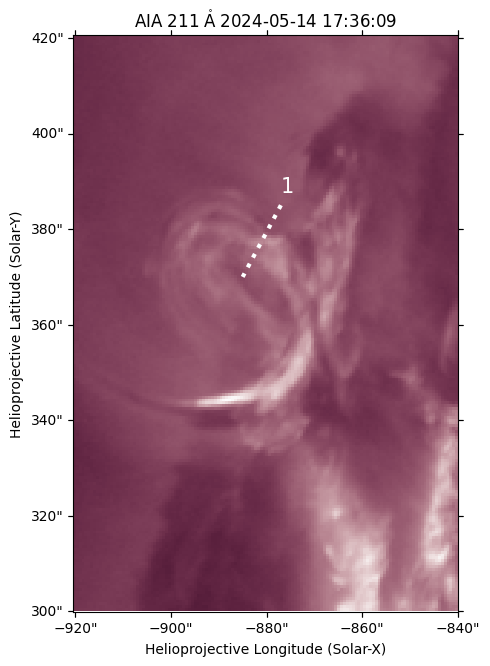

In [147]:
idx = 126
m = map_objects[idx]
norm = ImageNormalize(vmin=0, vmax=5e3, stretch=AsinhStretch())

# crop the region of interest
top_right   = SkyCoord(-840*u.arcsec, 420*u.arcsec, frame=m.coordinate_frame)
bottom_left = SkyCoord(-920*u.arcsec, 300*u.arcsec, frame=m.coordinate_frame)
m_submap = m.submap(bottom_left, top_right=top_right)

# define a line over the vortex
slit = SkyCoord(
    Tx=[-877, -885]*u.arcsec,
    Ty=[385, 370]*u.arcsec,
    frame=m_submap.coordinate_frame
)

fig = plt.figure(figsize=[5,7])
ax = fig.add_subplot(projection=m_submap)
m_submap.plot(axes=ax, norm=norm)
ax.plot_coord(slit, color='white', ls=':', lw=3)

# Convert the slit coordinates to pixel coordinates for annotation
start_pix, end_pix = m_submap.world_to_pixel(slit)
x1pix, y1pix = start_pix.value
# Annotate at the tip of the slit using pixel coordinates
ax.annotate('1', xy=(x1pix, y1pix), xytext=(0,180),
            textcoords='offset points', color='w', fontsize=15)
ax.grid(False)
fig.tight_layout()
plt.show()

In [148]:
# track how intensity evolves along the slit over the sequence of solar images
for m in map_objects:
    m.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=5e3, stretch=AsinhStretch())

intensity_stack = []
with tqdm(total=len(map_objects), desc='Stack intensities ...') as pbar:
    for m in map_objects:
        with SphericalScreen(m.observer_coordinate):
            _slit_pixelated = sunpy.map.pixelate_coord_path(m, slit)
        _slit_distance = _slit_pixelated.separation(_slit_pixelated[0])
        intensity = sunpy.map.sample_at_coords(m, _slit_pixelated)
        f_interp = interp1d(_slit_distance.to_value('arcsec'), intensity.value, fill_value='extrapolate', kind='linear')
        intensity_interp = f_interp(slit_distance.to_value('arcsec'))
        intensity_stack.append(u.Quantity(intensity_interp, intensity.unit))
        pbar.update(1)

# get the time array and the distance along slit in arcsec
time_array = [m.date.datetime for m in map_objects]
distance = slit_distance.to(u.arcsec)

Stack intensities ...: 100%|███████████████████████████████████████████████████████████████████| 452/452 [02:01<00:00,  3.71it/s]


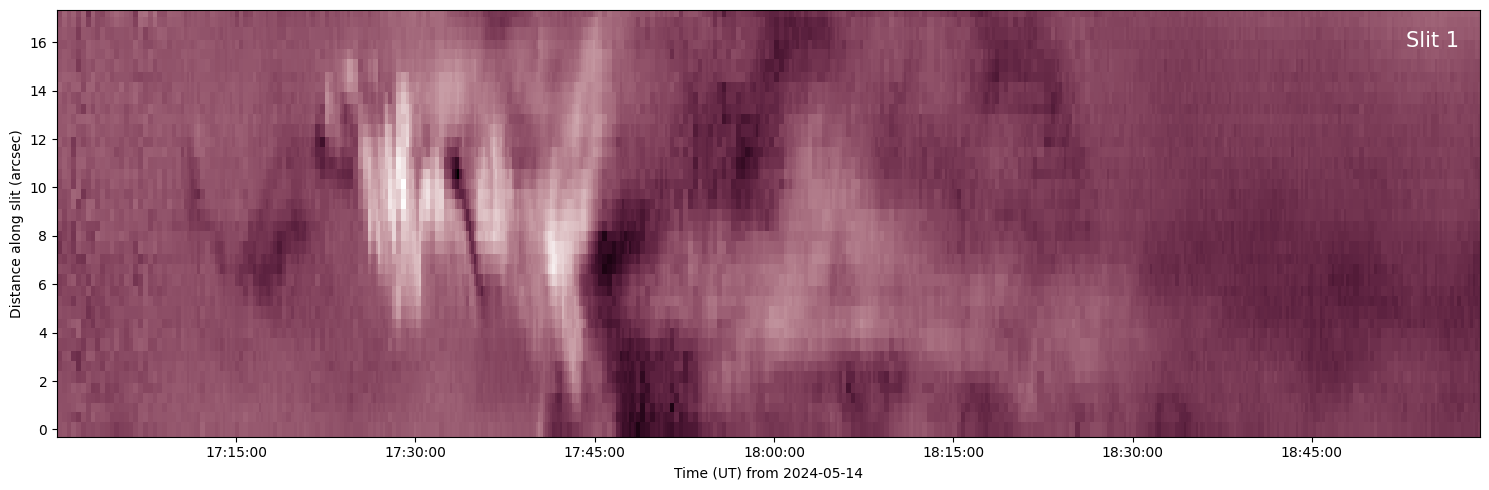

In [149]:
fig, ax = plt.subplots(figsize=[15,5])
ax.pcolormesh(time_array, distance.value, np.array(intensity_stack).T,
              norm=ImageNormalize(stretch=AsinhStretch()),
              cmap=sdoaia211)
ax.text(0.985, 0.95, 'Slit 1', transform=ax.transAxes,
        fontsize=15, color='white', verticalalignment='top', horizontalalignment='right')
ax.set_ylabel('Distance along slit (arcsec)')
ax.set_xlabel(f"Time (UT) from {time_array[0].strftime('%Y-%m-%d')}")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
fig.tight_layout()
plt.show()

In [171]:
print(len(dict_maps['171A']))
print(len(dict_maps['193A']))
print(len(dict_maps['211A']))
print(len(dict_maps['304A']))

582
0
452
592


# Make composite RGB maps

In [198]:
from skimage.transform import resize

In [199]:
dict_maps['171A'][177].data.shape, dict_maps['193A'][71].data.shape, dict_maps['211A'][126].data.shape, dict_maps['304A'][177].data.shape

((4094, 4094), (4096, 4096), (4096, 4096), (4096, 4096))

In [205]:
def enhance_contrast(image, vmin, vmax):
    """
    Enhance contrast by clipping and normalization.
    """
    image_clipped = np.clip(image, vmin, vmax)
    image_normalized = (image_clipped - vmin) / (vmax - vmin)
    return image_normalized


def calculate_percentiles(image, lower_percentile=3, upper_percentile=97):
    """
    Calculate vmin and vmax based on the 1st and 99th percentiles.
    """
    vmin = np.percentile(image, lower_percentile)
    vmax = np.percentile(image, upper_percentile)
    return vmin, vmax

In [440]:
m1 = dict_maps['171A'][177]
m2 = dict_maps['193A'][71]
m3 = dict_maps['211A'][126]

enhanced = False

# Determine the target shape (smallest shape among the three images)
target_shape = (min(m1.data.shape[0], m2.data.shape[0], m3.data.shape[0]),
                min(m1.data.shape[1], m2.data.shape[1], m3.data.shape[1]))

# Resize each image to the target shape
m1_resized = resize(m1.data, target_shape, preserve_range=True)
m2_resized = resize(m2.data, target_shape, preserve_range=True)
m3_resized = resize(m3.data, target_shape, preserve_range=True)

# Stack the resized images
rgb_image = np.stack([m1_resized, m2_resized, m3_resized], axis=-1)

In [441]:
# Normalize the data
m1_resized = (m1_resized - np.min(m1_resized)) / (np.max(m1_resized) - np.min(m1_resized))
m2_resized = (m2_resized - np.min(m2_resized)) / (np.max(m2_resized) - np.min(m2_resized))
m3_resized = (m3_resized - np.min(m3_resized)) / (np.max(m3_resized) - np.min(m3_resized))

# Stack the resized images into an RGB composite (each map corresponds to one color channel)
rgb_image = np.stack([m1_resized, m2_resized, m3_resized], axis=-1)

In [428]:
if enhanced:
    # Enhance contrast for each channel
    rgb_image_enhanced = np.zeros_like(rgb_image)
    for i in range(3):  # Process each channel independently
        vmin, vmax = calculate_percentiles(rgb_image[..., i])
        rgb_image_enhanced[..., i] = enhance_contrast(rgb_image[..., i], vmin, vmax)
    # Convert the 3D array to a 2D array by averaging the channels
    array_2d = np.mean(rgb_image_enhanced, axis=2)
else:
    # Convert the 3D array to a 2D array by averaging the channels
    array_2d = np.mean(rgb_image, axis=2)

# Create a SunPy map with the resulting array
m_rgb = sunpy.map.Map(array_2d, m1.meta)

In [450]:
# rgb = sunpy.map.Map(array_2d, m1.meta)
rgb_image.shape

(4094, 4094, 3)

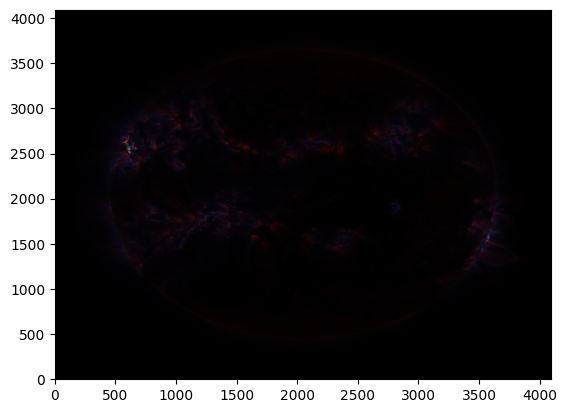

In [449]:
# Display the composite image
fig, ax = plt.subplots()
ax.imshow(rgb_image, aspect='auto', origin='lower')
plt.show()

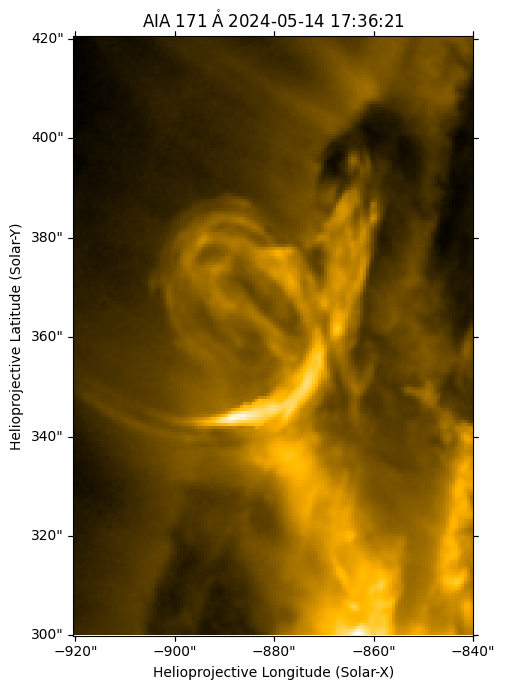

In [424]:
top_right   = SkyCoord(-840*u.arcsec, 420*u.arcsec, frame=m_rgb.coordinate_frame)
bottom_left = SkyCoord(-920*u.arcsec, 300*u.arcsec, frame=m_rgb.coordinate_frame)
m_rgb_submap = m_rgb.submap(bottom_left, top_right=top_right)

fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(projection=m_rgb_submap)
m_rgb_submap.plot(axes=ax, norm=LogNorm())
ax.grid(False)
fig.tight_layout()
plt.show()

In [270]:
# %matplotlib widget
# %matplotlib notebook
%matplotlib inline

# Plot multiple slits

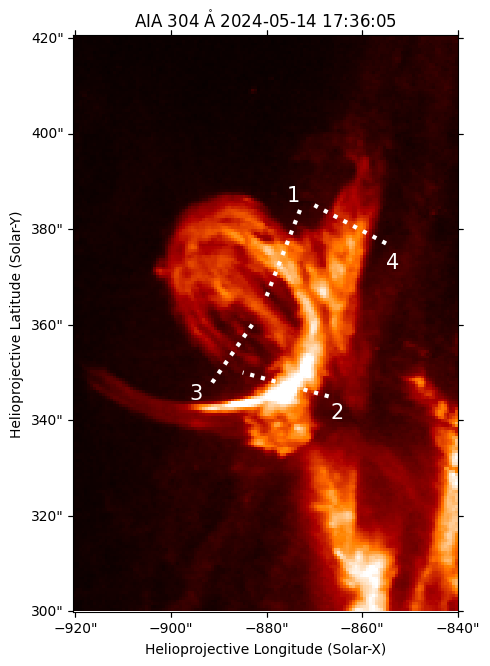

In [272]:
idx = 177
map_objects = dict_maps['304A']
m = map_objects[idx]
norm = ImageNormalize(vmin=0, vmax=5e2, stretch=AsinhStretch())

# crop the region of interest
top_right   = SkyCoord(-840*u.arcsec, 420*u.arcsec, frame=m.coordinate_frame)
bottom_left = SkyCoord(-920*u.arcsec, 300*u.arcsec, frame=m.coordinate_frame)
m_submap = m.submap(bottom_left, top_right=top_right)

# define a line over the vortex
slit1 = SkyCoord(
    Tx=[-867, -885]*u.arcsec,
    Ty=[345, 350]*u.arcsec,
    frame=m_submap.coordinate_frame
)

slit2 = SkyCoord(
    Tx=[-873, -880]*u.arcsec,
    Ty=[384, 366]*u.arcsec,
    frame=m_submap.coordinate_frame
)

slit3 = SkyCoord(
    Tx=[-883, -892]*u.arcsec,
    Ty=[360, 347]*u.arcsec,
    frame=m_submap.coordinate_frame
)

slit4 = SkyCoord(
    Tx=[-855, -870]*u.arcsec,
    Ty=[377, 385]*u.arcsec,
    frame=m_submap.coordinate_frame
)

fig = plt.figure(figsize=[5,7])
ax = fig.add_subplot(projection=m_submap)
m_submap.plot(axes=ax, norm=norm)
ax.plot_coord(slit1, color='white', ls=':', lw=3)
ax.plot_coord(slit2, color='white', ls=':', lw=3)
ax.plot_coord(slit3, color='white', ls=':', lw=3)
ax.plot_coord(slit4, color='white', ls=':', lw=3)

# Convert the slit coordinates to pixel coordinates for annotation
# Annotate at the tip of the slit using pixel coordinates
start_pix, end_pix = m_submap.world_to_pixel(slit1)
xpix, ypix = start_pix.value
ax.annotate('1', xy=(xpix, ypix), xytext=(-30,174), textcoords='offset points', color='w', fontsize=15)

start_pix, end_pix = m_submap.world_to_pixel(slit2)
xpix, ypix = start_pix.value
ax.annotate('2', xy=(xpix, ypix), xytext=(22,0), textcoords='offset points', color='w', fontsize=15)

start_pix, end_pix = m_submap.world_to_pixel(slit3)
xpix, ypix = start_pix.value
ax.annotate('3', xy=(xpix, ypix), xytext=(-45,55), textcoords='offset points', color='w', fontsize=15)

start_pix, end_pix = m_submap.world_to_pixel(slit4)
xpix, ypix = start_pix.value
ax.annotate('4', xy=(xpix, ypix), xytext=(0,74), textcoords='offset points', color='w', fontsize=15)

ax.grid(False)
fig.tight_layout()
plt.show()

Stack intensities ...: 100%|███████████████████████████████████████████████████████████████████| 592/592 [02:09<00:00,  4.57it/s]


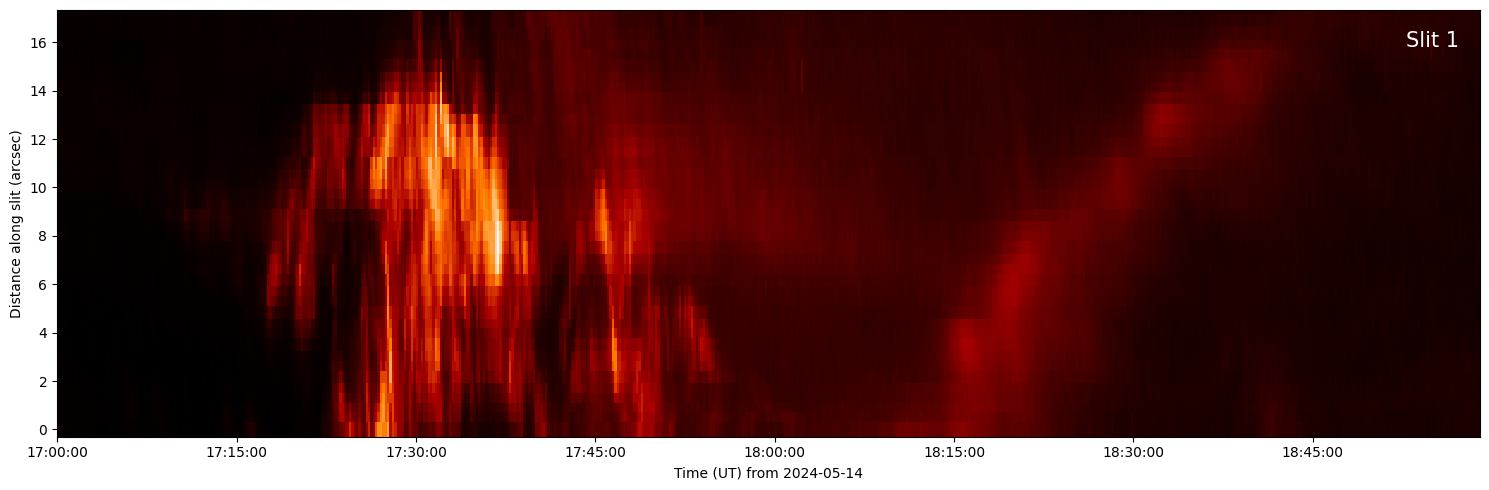

Stack intensities ...: 100%|███████████████████████████████████████████████████████████████████| 592/592 [01:47<00:00,  5.52it/s]


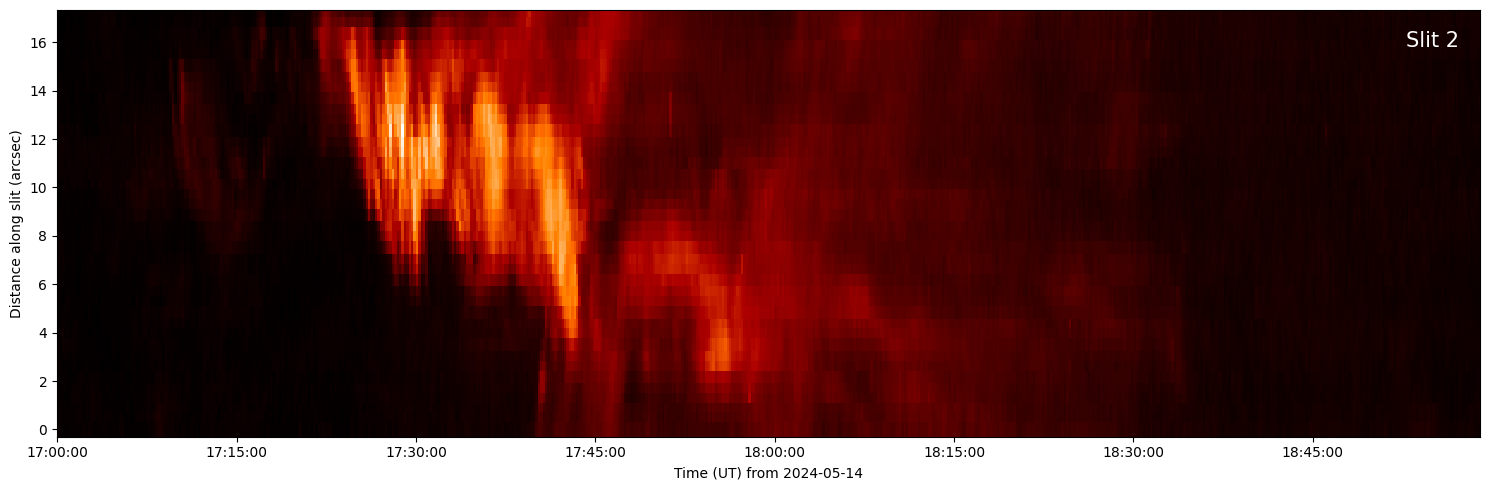

Stack intensities ...: 100%|███████████████████████████████████████████████████████████████████| 592/592 [01:42<00:00,  5.75it/s]


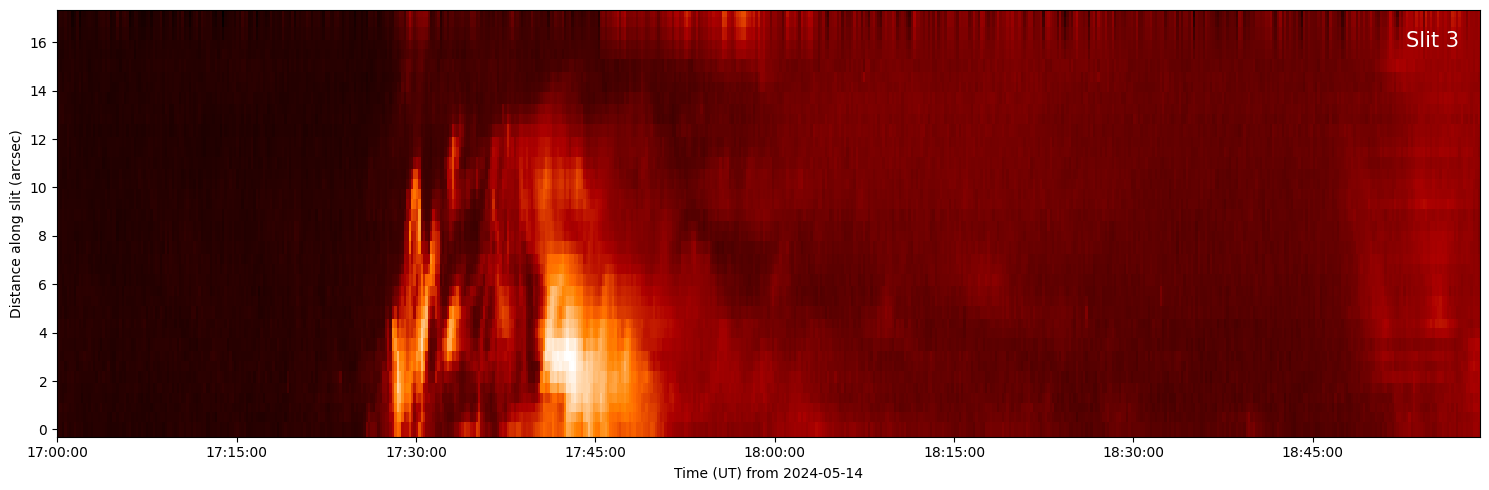

Stack intensities ...: 100%|███████████████████████████████████████████████████████████████████| 592/592 [01:38<00:00,  5.98it/s]


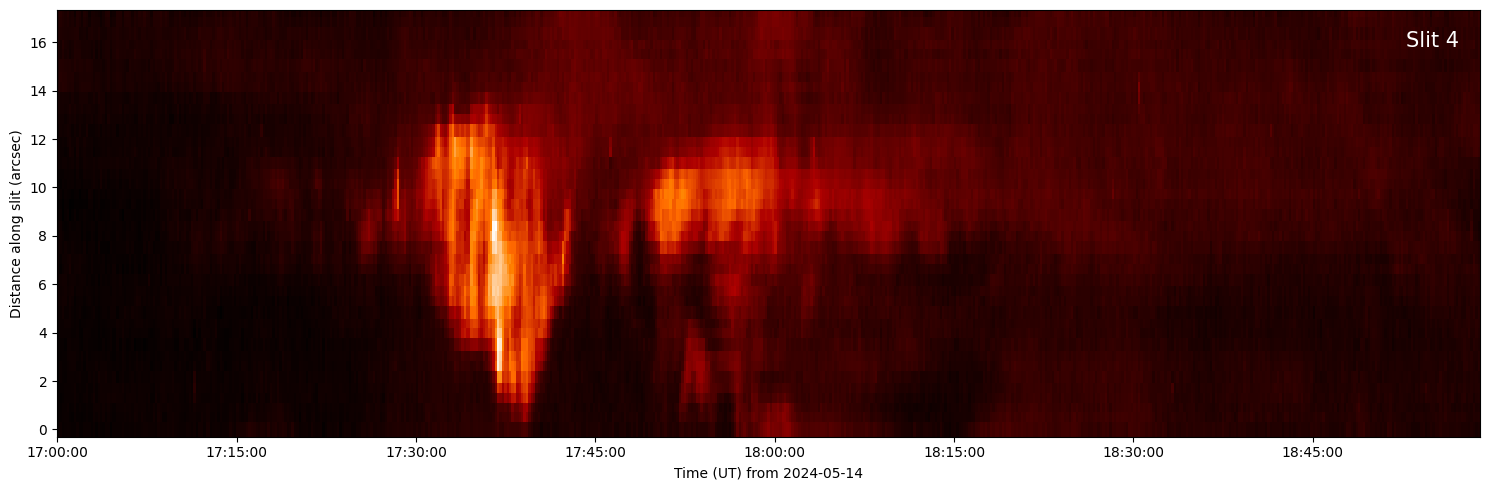

In [273]:
# track how intensity evolves along the slit over the sequence of solar images
for m in map_objects:
    m.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=5e2, stretch=AsinhStretch())

slits = [slit1, slit2, slit3, slit4]

for i, slit in enumerate(slits):
    intensity_stack = []
    with tqdm(total=len(map_objects), desc='Stack intensities ...') as pbar:
        for m in map_objects:
            with SphericalScreen(m.observer_coordinate):
                _slit_pixelated = sunpy.map.pixelate_coord_path(m, slit)
            _slit_distance = _slit_pixelated.separation(_slit_pixelated[0])
            intensity = sunpy.map.sample_at_coords(m, _slit_pixelated)
            f_interp = interp1d(_slit_distance.to_value('arcsec'), intensity.value, fill_value='extrapolate', kind='linear')
            intensity_interp = f_interp(slit_distance.to_value('arcsec'))
            intensity_stack.append(u.Quantity(intensity_interp, intensity.unit))
            pbar.update(1)
    
    # get the time array and the distance along slit in arcsec
    time_array = [m.date.datetime for m in map_objects]
    distance = slit_distance.to(u.arcsec)
    
    fig, ax = plt.subplots(figsize=[15,5])
    ax.pcolormesh(time_array, distance.value, np.array(intensity_stack).T,
                  norm=ImageNormalize(stretch=AsinhStretch()),
                  cmap=sdoaia304)
    ax.text(0.985, 0.95, f'Slit {i+1}', transform=ax.transAxes,
            fontsize=15, color='white', verticalalignment='top', horizontalalignment='right')
    ax.set_ylabel('Distance along slit (arcsec)')
    ax.set_xlabel(f"Time (UT) from {time_array[0].strftime('%Y-%m-%d')}")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    fig.tight_layout()
    plt.show()

In [283]:
np.array(time_array).shape, distance.shape, np.array(intensity_stack).T.shape

((592,), (40,), (40, 592))

In [312]:
# track how intensity evolves along the slit over the sequence of solar images
for m in map_objects:
    m.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=5e2, stretch=AsinhStretch())

intensity_stack = []
with tqdm(total=len(map_objects), desc='Stack intensities ...') as pbar:
    for m in map_objects:
        with SphericalScreen(m.observer_coordinate):
            _slit_pixelated = sunpy.map.pixelate_coord_path(m, slit1)
        _slit_distance = _slit_pixelated.separation(_slit_pixelated[0])
        intensity = sunpy.map.sample_at_coords(m, _slit_pixelated)
        f_interp = interp1d(_slit_distance.to_value('arcsec'), intensity.value, fill_value='extrapolate', kind='linear')
        intensity_interp = f_interp(slit_distance.to_value('arcsec'))
        intensity_stack.append(u.Quantity(intensity_interp, intensity.unit))
        pbar.update(1)

Stack intensities ...: 100%|███████████████████████████████████████████████████████████████████| 592/592 [01:38<00:00,  5.98it/s]


In [413]:
# get the time array and the distance along slit in arcsec
time_array = np.array([m.date.datetime for m in map_objects])
distance = slit_distance.to(u.arcsec).value
data = np.array(intensity_stack).T

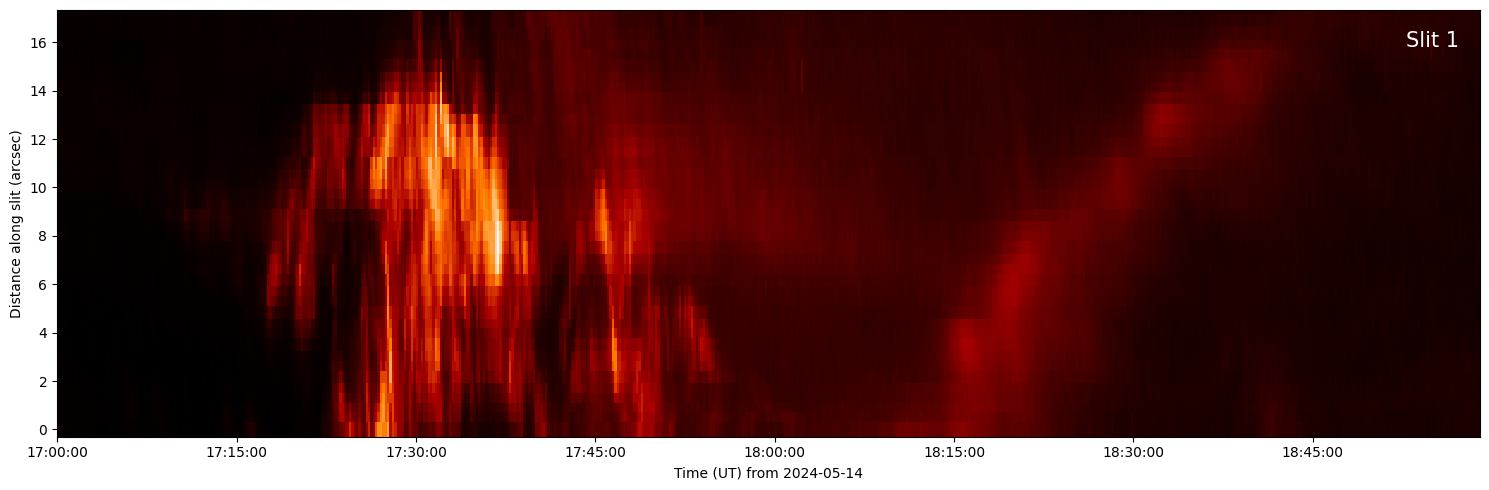

In [415]:
# Find the indices of the maximum values for each line curve
max_indices = np.argmax(data, axis=0)

fig, ax = plt.subplots(figsize=[15,5])
ax.pcolormesh(time_array, distance, data,
              norm=ImageNormalize(stretch=AsinhStretch()), cmap=sdoaia304)
ax.text(0.985, 0.95, 'Slit 1', transform=ax.transAxes,
        fontsize=15, color='white', verticalalignment='top', horizontalalignment='right')
ax.set_ylabel('Distance along slit (arcsec)')
ax.set_xlabel(f"Time (UT) from {time_array[0].strftime('%Y-%m-%d')}")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
fig.tight_layout()
plt.show()

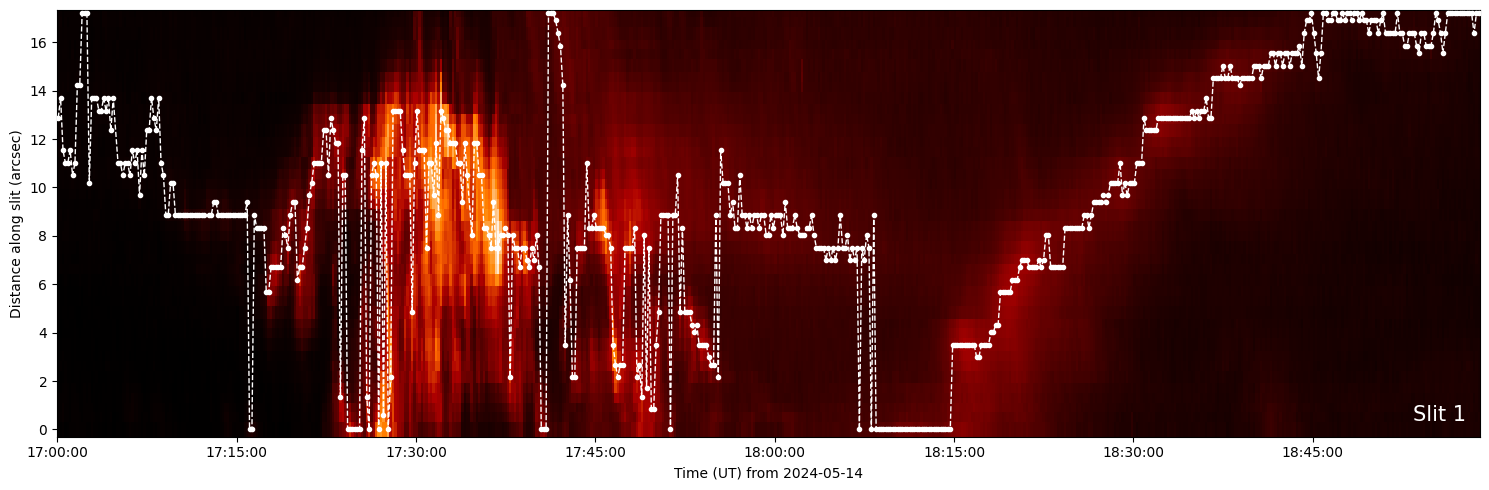

In [419]:
fig, ax = plt.subplots(figsize=[15,5])
ax.pcolormesh(time_array, distance, data,
              norm=ImageNormalize(stretch=AsinhStretch()),
              # norm=LogNorm(),
              cmap=sdoaia304)
ax.text(0.99, 0.075, 'Slit 1', transform=ax.transAxes,
        fontsize=15, color='white', verticalalignment='top', horizontalalignment='right')
ax.set_ylabel('Distance along slit (arcsec)')
ax.plot(time_array, distance[max_indices], 'o--', color='w', lw=1, ms=3, zorder=5)
ax.set_xlabel(f"Time (UT) from {time_array[0].strftime('%Y-%m-%d')}")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
fig.tight_layout()
plt.show()

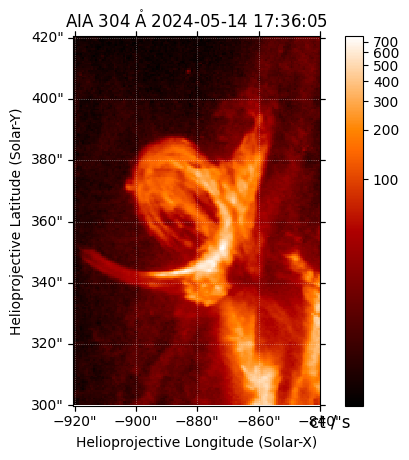

In [452]:
m_submap.peek()

In [498]:
# Define the rotation angle and center coordinate of the rectangle, as well as the width and height in physical units
rotation_angle = 125 * u.deg
center_coord = SkyCoord(-882 * u.arcsec, 379 * u.arcsec, frame=m_submap.coordinate_frame)
width = 6 * u.arcsec
height = 15 * u.arcsec

# We define a custom coordinate frame for the rotated rectangle by providing the center in the AIA coordinate frame
# and rotation angle to SkyOffsetFrame. We then define a 2-element SkyCoord in that custom coordinate frame
# for the bottom-left and top-right corners of the rectangle
offset_frame = SkyOffsetFrame(origin=center_coord, rotation=rotation_angle)
rectangle = SkyCoord(lon=[-1/2, 1/2] * width, lat=[-1/2, 1/2] * height, frame=offset_frame)

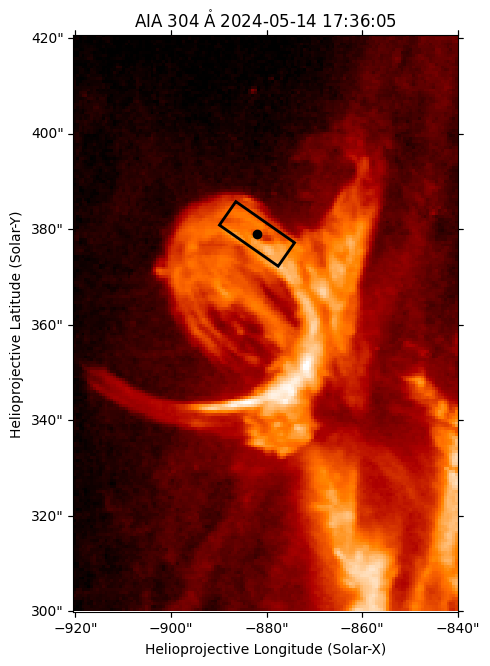

In [499]:
fig = plt.figure(figsize=[5,7])
ax = fig.add_subplot(projection=m_submap)
m_submap.plot(axes=ax, clip_interval=(1, 99.99) * u.percent)
ax.plot_coord(center_coord, 'o', color='k')
rect = m_submap.draw_quadrangle(
    rectangle,
    axes=ax,
    edgecolor='k',
    linestyle='-',
    linewidth=2
)
ax.grid(False)
fig.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord, SkyOffsetFrame
import sunpy.data.sample
import sunpy.map



all_hpc = sunpy.map.all_coordinates_from_map(aia_map)
all_hgs = all_hpc.transform_to('heliographic_stonyhurst')


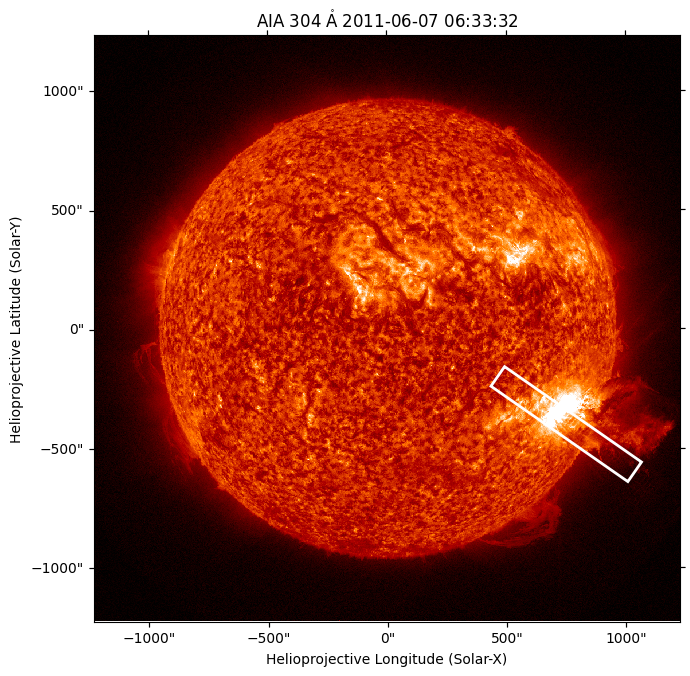

In [742]:
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord, SkyOffsetFrame
import sunpy.data.sample
import sunpy.map

# Load the map
aia_map = sunpy.map.Map(sunpy.data.sample.AIA_304_IMAGE)

# Define the rotation angle and center coordinate of the rectangle, as well as the width and height in physical units
rotation_angle = 125 * u.deg
center_coord = SkyCoord(750 * u.arcsec, -400 * u.arcsec, frame=aia_map.coordinate_frame)
width = 100 * u.arcsec
height = 700 * u.arcsec

# Define a custom coordinate frame for the rotated rectangle by providing the center in the AIA coordinate frame
# and rotation angle to SkyOffsetFrame. Then define a 2-element SkyCoord in that custom coordinate frame
# for the bottom-left and top-right corners of the rectangle
offset_frame = SkyOffsetFrame(origin=center_coord, rotation=rotation_angle)
rectangle = SkyCoord(lon=[-1/2, 1/2] * width, lat=[-1/2, 1/2] * height, frame=offset_frame)

# Plot the map with the rectangle
fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(projection=aia_map)
aia_map.plot(axes=ax, clip_interval=(1, 99.8) * u.percent)

aia_map.draw_quadrangle(
    rectangle,
    axes=ax,
    edgecolor='w',
    linestyle='-',
    linewidth=2
)
ax.grid(False)
fig.tight_layout()
plt.show()

In [743]:
aia_rotated = aia_map.rotate(angle=125 * u.deg)

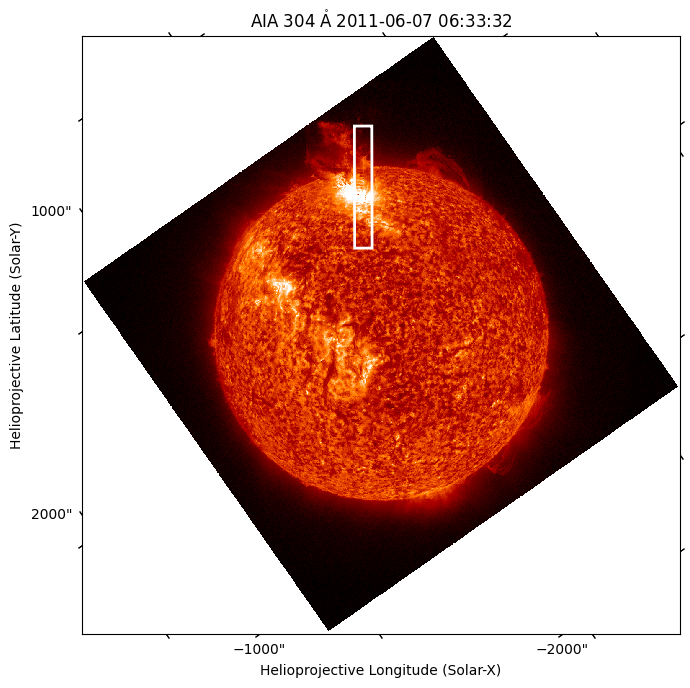

In [744]:
fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(projection=aia_rotated)
aia_rotated.plot(axes=ax, clip_interval=(1, 99.8)*u.percent)
aia_rotated.draw_quadrangle(
    rectangle,
    axes=ax,
    edgecolor='w',
    linestyle='-',
    linewidth=2
)
ax.grid(False)
fig.tight_layout()
plt.show()

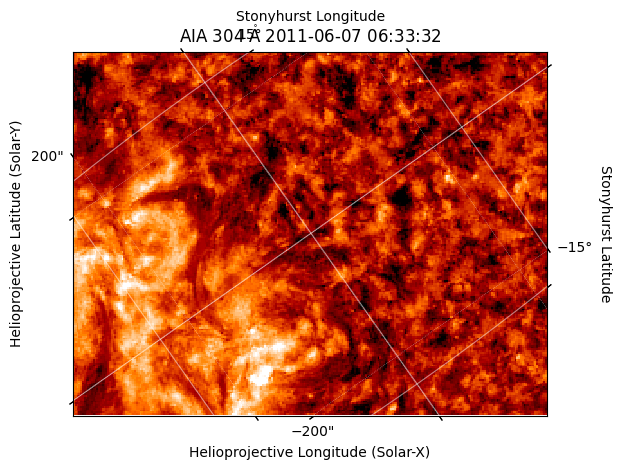

In [745]:
# extract the rectangle via its corners
x_deg, y_deg = rectangle.lon, rectangle.lat
tr_x, bl_x = x_deg
tr_y, bl_y = y_deg

top_right   = SkyCoord(tr_x, tr_y, frame=aia_rotated.coordinate_frame)
bottom_left = SkyCoord(bl_x, bl_y, frame=aia_rotated.coordinate_frame)

rect_submap = aia_rotated.submap(bottom_left, top_right=top_right)

fig = plt.figure()
ax = fig.add_subplot(projection=rect_submap)
rect_submap.plot(axes=ax, clip_interval=(1, 99.8)*u.percent)
rect_submap.draw_grid()
fig.tight_layout()
plt.show()

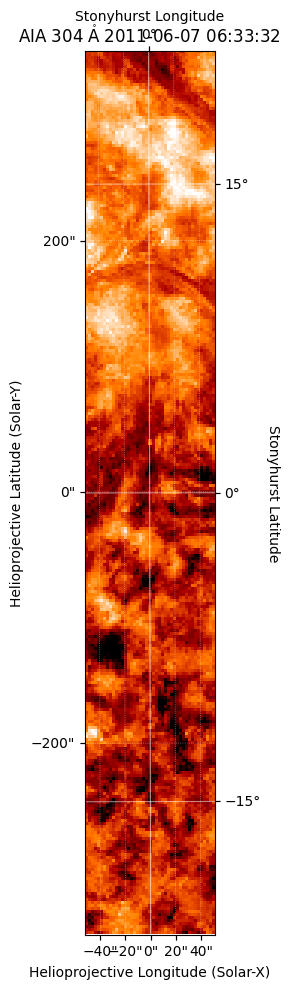

In [746]:
top_right   = SkyCoord(tr_x, tr_y, frame=aia_map.coordinate_frame)
bottom_left = SkyCoord(bl_x, bl_y, frame=aia_map.coordinate_frame)

rect_submap = aia_map.submap(bottom_left, top_right=top_right)

fig = plt.figure(figsize=[5,10])
ax = fig.add_subplot(projection=rect_submap)
rect_submap.plot(axes=ax, clip_interval=(1, 99.8)*u.percent)
rect_submap.draw_grid()
fig.tight_layout()
plt.show()

In [727]:
aia_rotated.world_to_pixel(rectangle).x

<Quantity 650.26854126 pix>

In [728]:
aia_rotated.pixel_to_world(*aia_rotated.world_to_pixel(rectangle).x)

<SkyCoord (Helioprojective: obstime=2011-06-07T06:33:33.574, rsun=696000.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2011-06-07T06:33:33.574, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
    (-0.00403132, 0.04792845, 1.51846029e+11)>): (Tx, Ty) in arcsec
    (42.68253909, 157.84892834)>

In [738]:
rect = aia_rotated.world_to_pixel(rectangle)
print(rect)
x_deg, y_deg = rect[0], rect[1]
tr_x, bl_x = x_deg
tr_y, bl_y = y_deg

top_right   = SkyCoord(tr_x, tr_y, frame=aia_rotated.coordinate_frame)
bottom_left = SkyCoord(bl_x, bl_y, frame=aia_rotated.coordinate_frame)

rect_submap = aia_rotated.submap(bottom_left, top_right=top_right)

fig = plt.figure(figsize=[5,10])
ax = fig.add_subplot(projection=rect_submap)
rect_submap.plot(axes=ax, clip_interval=(1, 99.8)*u.percent)
ax.grid(False)
fig.tight_layout()
plt.show()

PixelPair(x=<Quantity [650.26854126, 691.25479136] pix>, y=<Quantity [ 920.09681186, 1211.7832401 ] pix>)


UnitTypeError: Longitude instances require units equivalent to 'rad', so cannot set it to 'pix'.

In [ ]:
lofar_imagemap.pixel_to_world(lofar_centLoc[1], lofar_centLoc[0])

In [610]:
all_hpc = sunpy.map.all_coordinates_from_map(aia_map)
all_hgs = all_hpc.transform_to('heliographic_stonyhurst')
all_hgs

<SkyCoord (HeliographicStonyhurst: obstime=2011-06-07T06:33:33.574, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
    [[(nan, nan, nan), (nan, nan, nan), (nan, nan, nan), ...,
      (nan, nan, nan), (nan, nan, nan), (nan, nan, nan)],
     [(nan, nan, nan), (nan, nan, nan), (nan, nan, nan), ...,
      (nan, nan, nan), (nan, nan, nan), (nan, nan, nan)],
     [(nan, nan, nan), (nan, nan, nan), (nan, nan, nan), ...,
      (nan, nan, nan), (nan, nan, nan), (nan, nan, nan)],
     ...,
     [(nan, nan, nan), (nan, nan, nan), (nan, nan, nan), ...,
      (nan, nan, nan), (nan, nan, nan), (nan, nan, nan)],
     [(nan, nan, nan), (nan, nan, nan), (nan, nan, nan), ...,
      (nan, nan, nan), (nan, nan, nan), (nan, nan, nan)],
     [(nan, nan, nan), (nan, nan, nan), (nan, nan, nan), ...,
      (nan, nan, nan), (nan, nan, nan), (nan, nan, nan)]]>

In [616]:
# [x for x in dir(np) if not x.startswith('_')]

In [618]:
segment_mask = np.logical_not(rectangle)
# segment_mask |= np.isnan(all_hgs.lon)

In [619]:
segment_mask

array([False, False], dtype=object)

In [ ]:
# extract the rectangle via its corners
tr_x, tr_y = ??, ??
bl_x, bl_y = ??, ??

top_right = SkyCoord(tr_x * u.arcsec, tr_y * u.arcsec, frame=aia_map.coordinate_frame)
bottom_left = SkyCoord(bl_x * u.arcsec, bl_y * u.arcsec, frame=aia_map.coordinate_frame)

rect_submap = aia_map.submap(bottom_left, top_right=top_right)

In [608]:
vertices = rect.get_verts()

# Extract x and y coordinates
x_coords = vertices[:, 0]
y_coords = vertices[:, 1]

# Find the bottom-left (min x, min y)
bottom_left = [x_coords.min(), y_coords.min()]
bottom_left = [round(x) for x in bottom_left]

# Find the top-right (max x, max y)
top_right = [x_coords.max(), y_coords.max()]
top_right = [round(x) for x in top_right]

bl_x, bl_y = bottom_left
tr_x, tr_y = top_right

print(f"Bottom-left corner: {bottom_left}")
print(f"Top-right corner: {top_right}")

m_submap.data.T[bl_y:tr_y, bl_x:tr_x]

Bottom-left corner: [99, 179]
Top-right corner: [99, 179]


array([], shape=(0, 0), dtype='>f8')

In [607]:
m_submap.data.T.shape

(134, 201)

In [550]:
# Define the center, width, height, and rotation of the rectangle
rotation_angle = 125 * u.deg
center_coord = SkyCoord(-882 * u.arcsec, 379 * u.arcsec, frame=m_submap.coordinate_frame)
width = 6 * u.arcsec
height = 15 * u.arcsec

# Define the offset frame for the rotated rectangle
offset_frame = SkyOffsetFrame(origin=center_coord, rotation=rotation_angle)
rectangle_corners = SkyCoord(lon=[-1/2, 1/2] * width, lat=[-1/2, 1/2] * height, frame=offset_frame)

# Convert the rectangle corners to pixel coordinates
bottom_left_pixel = m_submap.wcs.world_to_pixel(rectangle_corners[0])
top_right_pixel = m_submap.wcs.world_to_pixel(rectangle_corners[1])

# Step 2: Make slices from pixel coordinates to define the submap
bl_x, bl_y = bottom_left_pixel
tr_x, tr_y = top_right_pixel

# Convert to integers for slicing
bl_x, bl_y = int(bl_x), int(bl_y)
tr_x, tr_y = int(tr_x), int(tr_y)

# Define the submap by slicing the pixel data
submap_data = m_submap.data.T[bl_y:tr_y, bl_x:tr_x]

# # Step 3: Extract the pixel values from the submap
# pixels_within_rectangle = submap.data

# # Step 4: Sum the pixel values into a 1D array
# summed_pixels = np.sum(pixels_within_rectangle, axis=0)
# one_d_array = np.sum(summed_pixels)

# # Optional: Print or use the 1D array for further analysis
# print(one_d_array)

# # Plot the submap if needed
# fig = plt.figure(figsize=[5, 7])
# ax = fig.add_subplot(projection=submap)
# submap.plot(axes=ax, clip_interval=(1, 99.99) * u.percent)
# plt.show()

In [551]:
top_right = SkyCoord(0 * u.arcsec, -200 * u.arcsec, frame=m_submap.coordinate_frame)
bottom_left = SkyCoord(-900 * u.arcsec, -900 * u.arcsec, frame=m_submap.coordinate_frame)
swap_submap = swap_map.submap(bottom_left, top_right=top_right)

(array(56.11937372), array(142.43881884))

In [552]:
m_submap.wcs.world_to_pixel(rectangle_corners[1])

(array(70.86270494), array(119.90748958))

In [530]:
tr_x, tr_y

(56, 142)

In [532]:
m_submap.data.T.shape

(134, 201)

In [533]:
bl_y,tr_y, bl_x,tr_x

(119, 142, 70, 56)

In [668]:
# Define the rotation angle and center coordinate of the rectangle, as well as the width and height in physical units
rotation_angle = 125 * u.deg
center_coord = SkyCoord(-882 * u.arcsec, 379 * u.arcsec, frame=m_submap.coordinate_frame)
width = 6 * u.arcsec
height = 15 * u.arcsec

# We define a custom coordinate frame for the rotated rectangle by providing the center in the AIA coordinate frame
# and rotation angle to SkyOffsetFrame. We then define a 2-element SkyCoord in that custom coordinate frame
# for the bottom-left and top-right corners of the rectangle
offset_frame = SkyOffsetFrame(origin=center_coord, rotation=rotation_angle)
rectangle = SkyCoord(lon=[-1/2, 1/2] * width, lat=[-1/2, 1/2] * height, frame=offset_frame)

x_pix, y_pix = m_submap.wcs.world_to_pixel(rectangle)
x1, x2 = x_pix
y1, y2 = y_pix

x1, x2, y1, y2

(56.119373722262935, 70.86270493961274, 142.43881883984056, 119.90748958486972)

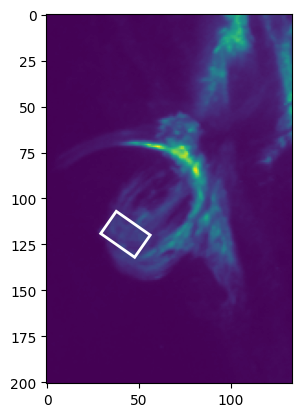

In [669]:
fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(m_submap.data)
# ax.imshow(m_submap.data, origin='lower')

# Define the width and height of the rectangle
width = x2 - x1
height = y1 - y2  # Subtract because y1 is greater than y2
rect = patches.Rectangle((x1, y2), width, height, angle=125, linewidth=2, edgecolor='w', facecolor='none')
ax.add_patch(rect)

plt.show()

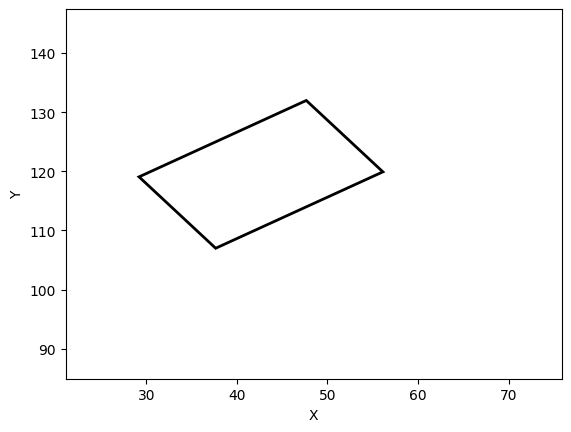

In [636]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Define the coordinates of the rectangle corners
x1, x2 = 56.119373722262935, 70.86270493961274
y1, y2 = 142.43881883984056, 119.90748958486972

# Create a new figure and axis
fig, ax = plt.subplots()


# Create a Rectangle patch
rect = patches.Rectangle((x1, y2), width, height, angle=125, linewidth=2, edgecolor='black', facecolor='none')
ax.add_patch(rect)

# Set the limits for the axes based on the rectangle coordinates
ax.set_xlim([x1 - 35, x2 + 5])
ax.set_ylim([y2 - 35, y1 + 5])

# Label the axes
ax.set_xlabel('X')
ax.set_ylabel('Y')

# Display the plot
plt.show()